# Face Mask Image Classification – Capstone 2

## Objective
The goal of this project is to build a deep learning image classification model
to detect whether a person is wearing a face mask or not.

This notebook focuses on:
- Dataset exploration (EDA for images)
- Data quality checks
- Baseline model training
- Model evaluation

Production deployment, monitoring, and Kubernetes orchestration
are implemented separately in scripts.


### Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import classification_report, confusion_matrix


### Dataset Structure Check

In [3]:
DATA_DIR = "data/processed"

for split in ["train", "val"]:
    print(f"\n{split.upper()} SET")
    for cls in os.listdir(os.path.join(DATA_DIR, split)):
        n = len(os.listdir(os.path.join(DATA_DIR, split, cls)))
        print(f"{cls}: {n} images")



TRAIN SET
no_mask: 7168 images
mask: 7074 images

VAL SET
no_mask: 1536 images
mask: 1516 images


### Visualize Sample Images (EDA)

MASK examples


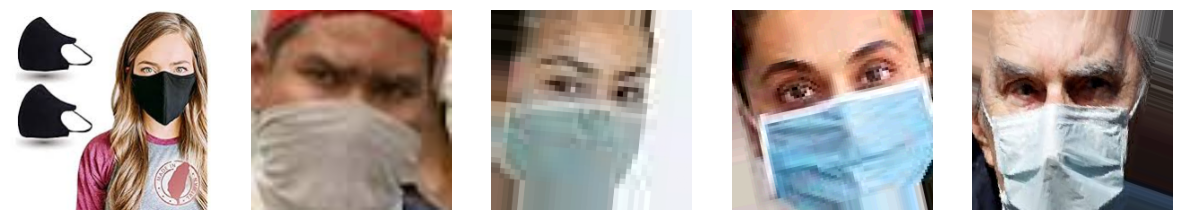

NO MASK examples


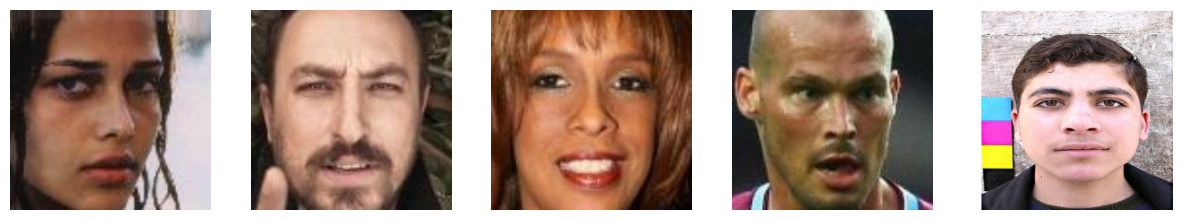

In [4]:
def show_images(folder, n=5):
    images = random.sample(os.listdir(folder), n)
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        path = os.path.join(folder, img)
        image = plt.imread(path)
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

print("MASK examples")
show_images("data/processed/train/mask")

print("NO MASK examples")
show_images("data/processed/train/no_mask")


### Image Transformations

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


### Datasets & DataLoaders

In [6]:
train_ds = datasets.ImageFolder("data/processed/train", transform=train_transform)
val_ds = datasets.ImageFolder("data/processed/val", transform=val_transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

class_names = train_ds.classes
class_names


['mask', 'no_mask']

### Model Definition (ResNet18)

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yazadanparast/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [02:15<00:00, 346kB/s]


### Training Loop (Short, Notebook-only)

⚠️ Important:

This is for validation only.

Final training happens in train.py.

In [9]:
#
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


### Validation Loop

In [10]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            targets.extend(y.numpy())

    return preds, targets


### Train for a Few Epochs

In [13]:
for epoch in range(5):
    loss = train_one_epoch(model, train_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 0.0174
Epoch 2, Loss: 0.0082
Epoch 3, Loss: 0.0093
Epoch 4, Loss: 0.0161
Epoch 5, Loss: 0.0052


### Evaluation Metrics

In [14]:
preds, targets = evaluate(model, val_dl)

print(classification_report(targets, preds, target_names=class_names))


              precision    recall  f1-score   support

        mask       1.00      1.00      1.00      1516
     no_mask       1.00      1.00      1.00      1536

    accuracy                           1.00      3052
   macro avg       1.00      1.00      1.00      3052
weighted avg       1.00      1.00      1.00      3052



### Confusion Matrix

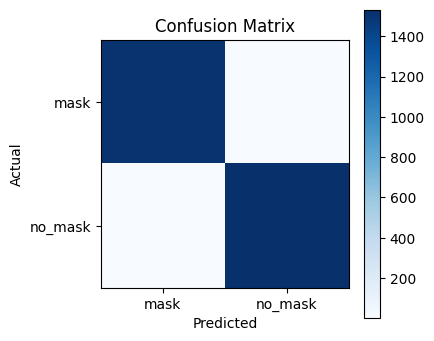

In [15]:
cm = confusion_matrix(targets, preds)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


## Observations

- The dataset is balanced enough for binary classification.
- The model converges quickly using transfer learning.
- Most misclassifications occur in partially occluded faces.
- The trained model is suitable for deployment as an inference service.


## Conclusion

This notebook validated the feasibility of a CNN-based approach
for face mask classification.

The final system is deployed using:
- FastAPI for inference
- Docker for containerization
- Kubernetes (kind) for orchestration
- Monitoring for prediction drift

Training and serving logic are separated from this notebook
to ensure reproducibility and production readiness.
